In [ ]:
import acoular as ac
from IPython.core.display import HTML
from IPython.core.magic import register_line_magic
from IPython.display import Audio

def css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()

In [ ]:
import urllib
from pathlib import Path

# download time data file
data_path = Path('data')
if not data_path.exists():
    print("create data directory")
    data_path.mkdir(parents=True, exist_ok=True)
    
td = data_path / "2015-08-12_16-55-10_n1ug_no_grid_1_4_derotated.h5"
if not td.exists():
    print('Cannot find time data file. Downloading...')
    url = 'https://tubcloud.tu-berlin.de/s/ya7ejrZno2znjtp/download/2015-08-12_16-55-10_n1ug_no_grid_1_4_derotated.h5'
    urllib.request.urlretrieve(url, td)
    print("download finished.")
    print(f'file location: {td}')

# download cache file
cache_path = Path(ac.config.cache_dir) 
if not cache_path.exists():
    print("create cache directory")
    cache_path.mkdir(parents=True, exist_ok=True)

cd = cache_path / "2015-08-12_16-55-10_n1ug_no_grid_1_4_derotated_cache.h5"
if not cd.exists():
    print('Cannot find cache file. Downloading...')
    url = 'https://tubcloud.tu-berlin.de/s/NfkzGm4WjioSywq/download/2015-08-12_16-55-10_n1ug_no_grid_1_4_derotated_cache.h5'
    urllib.request.urlretrieve(url, cd)
    print("download finished.")
    print(f'file location: {cd}')


In [ ]:
%matplotlib inline

# for the purpose of readability, we will outsource the plotting functions to the head of the notebook
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

vent_bg = plt.imread(Path().cwd() / 'img' / 'n1ug.png')
trailing_color = mcolors.to_rgb('#0C3762')  # Convert to RGB
leading_color = mcolors.to_rgb('#A81D1E')  # Convert to RGB
trailing_edges = np.array([[0, 0.15], [-0.05, 0.15], [-0.05, 0.245], [0, 0.25]]).T
leading_edges = np.array([[0, 0.15], [0.05, 0.15], [0.05, 0.245], [0, 0.25]]).T

def plot_rotor(ax):
    ax.imshow(vent_bg, extent=[-0.25,0.25,-0.25,0.25])
    ax.set_xlabel('x/m')
    ax.set_ylabel('y/m')


def plot_setup_3D(ax, mics, grid):
    mic_idx = 35
    grid_idx = 100
    ax.scatter(mics.pos[0], mics.pos[1], mics.pos[2], c='C0')
    ax.scatter(grid.pos[0], grid.pos[1], grid.pos[2], c='C4', s=0.5)
    # add cross at origin
    ax.plot([0], [0], [0], '+C3')
    ax.quiver(grid.pos[0,grid_idx], grid.pos[1,grid_idx], grid.pos[2,grid_idx], 
                mics.pos[0,mic_idx]-grid.pos[0,grid_idx], mics.pos[1,mic_idx]-grid.pos[1,grid_idx], 
                mics.pos[2,mic_idx]-grid.pos[2,grid_idx], color='gray', arrow_length_ratio=0.0)
    # and from the grid to the origin
    ax.quiver(0, 0, 0, grid.pos[0,grid_idx], grid.pos[1,grid_idx], grid.pos[2,grid_idx], color='gray', arrow_length_ratio=0.0)
    # add text
    ax.text(mics.pos[0, mic_idx] / 2, mics.pos[1, mic_idx] / 2, mics.pos[2, mic_idx] / 2, '$r_{t,m}$', color='black')
    ax.text(grid.pos[0, grid_idx] / 2, grid.pos[1, grid_idx] / 2, grid.pos[2, grid_idx] / 2, '$r_{t,0}$', color='black')
    ax.set_xlabel('x/m')
    ax.set_ylabel('y/m')
    ax.set_zlabel('z/m')
    ax.set_aspect('equal')
    ax.set_facecolor('white')
    ax.view_init(50, 0, 90)

def _plot_mics(ax, mics, angle=0, plot_channel_numbers=False):
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    rpos = rotation_matrix @ mics.pos[:2, :]
    for i in np.arange(mics.num_mics):
        ax.plot(rpos[0,i], rpos[1,i], 'oC0')
        if plot_channel_numbers:
            ax.text(rpos[0,i]+0.005, rpos[1,i]+0.005,str(i+1), fontsize=6)

def plot_setup(ax, mics, angle=0):
    plot_rotor(ax)
    _plot_mics(ax, mics, angle)
    ax.set_aspect('equal')

def plot_sourcemap(ax, smap, grid, dyn=20):
    plot_rotor(ax)
    mx = np.max(smap)
    use = (smap > mx-dyn)
    norm = plt.Normalize(vmin=mx-dyn, vmax=mx)
    ax.scatter(grid.pos[0][use], grid.pos[1][use], 
               c=smap[use], s=12, 
               edgecolors='none', 
               cmap=plt.cm.hot_r, norm=norm)

def plot_3rd_octave_bands(ax, te, le, method):
    # Compute third-octave band results
    freqs = method.freq_data.fftfreq()
    freqs = freqs[freqs >= 500]
    (f_borders, p_3rd_trailing, f_center) = ac.tools.barspectrum(te, freqs, 3, bar=True)
    (_, p_3rd_leading, _) = ac.tools.barspectrum(le, freqs, 3, bar=True)
    ax.set_xscale('symlog')
    ax.plot(f_borders, ac.L_p(p_3rd_trailing), label="Trailing Edge", color=trailing_color, linestyle="-")
    ax.plot(f_borders, ac.L_p(p_3rd_leading), label="Leading Edge", color=leading_color, linestyle="-")
    ax.set_title(method.__class__.__name__.strip('Beamformer'))
    ax.set_ylabel(r'$L_p$ / dB')
    ax.set_ylim(10, 80)
    ax.set_xlim(1000, 16000)
    ax.set_xticks([1000, 2000, 4000, 8000, 16000],["1k", "2k", "4k", "8k", "16k"])
    ax.set_xlabel(r'$f$/Hz')
    ax.grid(True)
    ax.legend()

# a function to rotate the edges of the sector
def rotate_edges(edges, angle):
    rotation_matrix = np.array([[np.cos(np.radians(angle)), -np.sin(np.radians(angle))], [np.sin(np.radians(angle)), np.cos(np.radians(angle))]])
    return (rotation_matrix @ edges).T.flatten().tolist()

    
#%% Line magics for the notebook
mics = ac.MicGeom(file = Path().cwd() / 'mic' / 'ring64.xml')
grid = ac.ImportGrid(file=Path().cwd() / 'grid' / 'fan_grid.xml')
vra_time_data = ac.TimeSamples(file=Path().cwd() / 'data' / '2015-08-12_16-55-10_n1ug_no_grid_1_4_derotated.h5')
freq_data = ac.PowerSpectra(source=vra_time_data, block_size=256, window='Hanning', overlap='50%')
flow = ac.RotatingFlow(rps = -1486.083/-60, v0=0)
env = ac.GeneralFlowEnvironment(ff = flow, c = 350.32)
steer = ac.SteeringVector(
    grid=grid, mics=mics, env=env, ref=np.array([0,0,0]), steer_type='true level')
beamformer = ac.BeamformerBase(steer=steer, freq_data=freq_data)
deconvolution = ac.BeamformerCleansc(freq_data=freq_data, steer=steer)
inverse = ac.BeamformerCMF(freq_data=freq_data, steer=steer, method='LassoLarsBIC')


@register_line_magic
def plot_mics(line):
    fig, ax = plt.subplots()
    plot_setup(ax, mics)
    ax.set_title(f"Microphone Array Setup ($r={mics.aperture:.2f}$ m, $M={mics.num_mics}$)")

@register_line_magic
def plot_grid(line):
    fig, ax = plt.subplots()
    plot_setup(ax, mics)
    ax.plot(grid.pos[0], grid.pos[1], 'oC4', markersize=0.5)
    ax.set_title(f"Evaluation Setup (G={grid.size})")

@register_line_magic
def play_audio(line):
    Audio(vra_time_data.data[:,0], rate=vra_time_data.sample_freq)

@register_line_magic
def plot_beamforming(line):
    fig, ax = plt.subplots(1, 3, figsize=(12,4))
    for i, freq in enumerate([2000, 5000, 8000]):
        bbmap = ac.L_p(beamformer.synthetic(freq, num=3))
        plot_sourcemap(ax[i], bbmap, grid, dyn=5)
        fig.colorbar(ax[i].collections[0], ax=ax[i], orientation='horizontal', label=r'$L_p$/dB')
        ax[i].set_title(f"{freq} Hz")

@register_line_magic
def plot_deconvolution(line):
    fig, ax = plt.subplots(1, 3, figsize=(12,4))
    for i, freq in enumerate([2000, 5000, 8000]):
        bbmap = ac.L_p(deconvolution.synthetic(freq, num=3))
        plot_sourcemap(ax[i], bbmap, grid, dyn=15)
        fig.colorbar(ax[i].collections[0], ax=ax[i], orientation='horizontal', label=r'$L_p$/dB')
        ax[i].set_title(f"{freq} Hz")

@register_line_magic
def plot_inverse(line):
    fig, ax = plt.subplots(1, 3, figsize=(12,4))
    for i, freq in enumerate([2000, 5000, 8000]):
        bbmap = ac.L_p(inverse.synthetic(freq, num=3))
        plot_sourcemap(ax[i], bbmap, grid, dyn=15)
        fig.colorbar(ax[i].collections[0], ax=ax[i], orientation='horizontal', label=r'$L_p$/dB')
        ax[i].set_title(f"{freq} Hz")

@register_line_magic
def plot_spectra(line):
    trailing_sector = ac.MultiSector(sectors=[])
    leading_sector = ac.MultiSector(sectors=[])
    def rotate_edges(edges, angle):
        rotation_matrix = np.array([[np.cos(np.radians(angle)), -np.sin(np.radians(angle))], [np.sin(np.radians(angle)), np.cos(np.radians(angle))]])
        return (rotation_matrix @ edges).T.flatten().tolist()
    def calculate_spectra(method):
        for i_blade in range(9):
            angle = i_blade * 40
            trailing_sector.sectors.append(
                ac.PolySector(edges = rotate_edges(trailing_edges, angle))
            )
            leading_sector.sectors.append(
                ac.PolySector(edges = rotate_edges(leading_edges, angle))
            )
        trailing_edges_spectrum = method.integrate(sector=trailing_sector)
        leading_edges_spectrum = method.integrate(sector=leading_sector)
        return (trailing_edges_spectrum, leading_edges_spectrum)
    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharex=True)
    for ax, method in zip(axes, [deconvolution, inverse]):
        trailing_edges_spectrum, leading_edges_spectrum = calculate_spectra(method)
        plot_3rd_octave_bands(ax, trailing_edges_spectrum, leading_edges_spectrum, method)

@register_line_magic
def plot_sectors(line):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True)
    plot_rotor(ax)  # Ensure this function is properly defined
    for i, deg in enumerate(range(0, 360, 40)):
        rotation_matrix = np.array([
            [np.cos(np.radians(deg)), -np.sin(np.radians(deg))], 
            [np.sin(np.radians(deg)), np.cos(np.radians(deg))]
        ])
        te = rotation_matrix @ trailing_edges
        le = rotation_matrix @ leading_edges
        ax.add_patch(
            Polygon(te.T, closed=True, edgecolor=trailing_color, facecolor='none', alpha=1, linewidth=1, zorder=2))
        ax.add_patch(
            Polygon(le.T, closed=True, edgecolor=leading_color, facecolor='none', alpha=1, linewidth=1, zorder=2))
    ax.axis('off')
    ax.set_xlim(-0.40,0.40)
    ax.set_ylim(-0.40,0.40)
    ax.legend(['Trailing Edge', 'Leading Edge'], loc='upper right')

# In an interactive session, we need to delete these to avoid
# name conflicts for automagic to work on line magics.
del plot_mics, plot_grid, play_audio, plot_beamforming, plot_deconvolution, plot_inverse, plot_spectra, plot_sectors

<img src="img/DAGA_logo.png" alt="DAGA Logo" style="width:160px; position:absolute; top:20px; right:0px;">
<img src="img/TU-lang.png" alt="TU Logo" style="width:230px; position:absolute; top:0px; right:180px;">

<h1 style="margin-top: 180px; margin-bottom: 50px; color: #A81D1E;">An Interactive Tutorial on Advanced Microphone Array Methods for Acoustic Source Mapping</h1>
<h3 style="margin-top: 50px; margin-bottom: 50px; color: #434343;">Adam Kujawski, Mikolaj Czuchaj, Gert Herold, Oliver Lylloff, Art J. R. Pelling, Ennes Sarradj</h3>

<h5 style="margin-top: 50px; margin-bottom: 100px; color: #434343;">Jupyter Notebook available at <a href="https://github.com/acoular/workshop_DAS-DAGA-2025">https://github.com/acoular/workshop_DAS-DAGA-2025</a></h5>


## Introduction

[//]: # "covered measurements were discussed in article Sound prediction methods for axial fans"


<div style="display: flex; align-items: center;">
    <div style="flex: 80%; padding-right: 10px;">
        <!-- <h6 style="...">Motivation:</h6>
        <ul>
            <li> Axial fans are a common and increasing source of noise (ventilation / cooling systems, heat pumps, etc.)</li>
        </ul> -->
        <h6 style="...">Agenda:</h6>
        <ul>
            <li>Analyze microphone array data from a low-pressure axial fan benchmark</li>
            <li>Apply advanced microphone array methods to investigate flow-induced noise mechanisms</li>
            <ul>
                <li>Create source mappings with three different microphone array methods</li>
                <li>Calculate and analyze acoustic spectra of leading and trailing edge noise components</li>
            </ul>
        </ul>
    </div>
    <div style="flex: 20%; text-align: right;">
        <img src="img/Akustik_Journal.png" width="500">
    </div>
</div>


In [ ]:
# Let's start by importing acoular
import acoular as ac

## Experimental Setup

* Standardized inlet test chamber according to ISO 5801 (Experimental Setup from <a href="#Zenger2016">[1]</a>)
* Flow rate coefficient $\Phi=\frac{4 \dot{V}}{\pi^2 D^3 n} = 0.18$

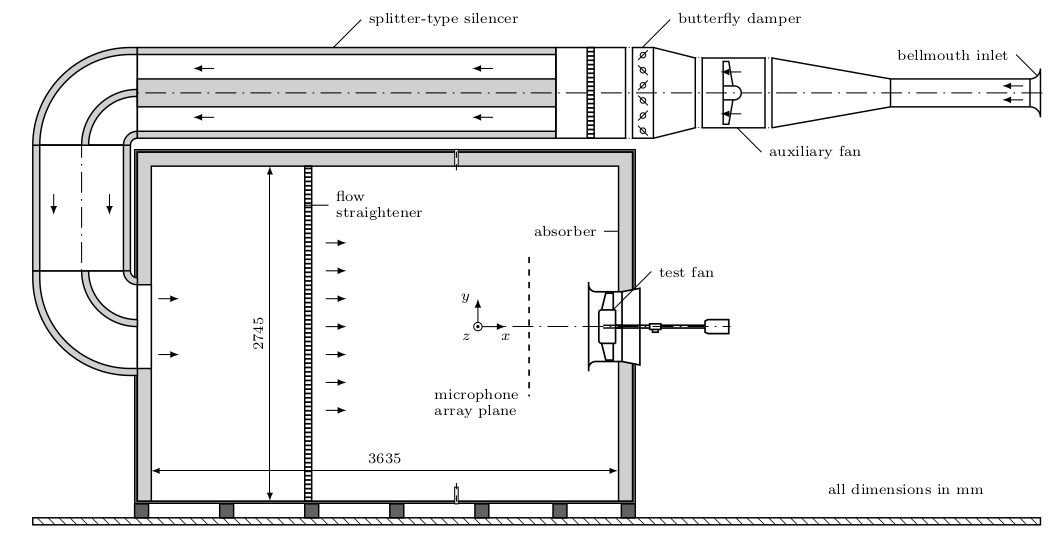

In [ ]:
# build the microphone array setup
mics = ac.MicGeom(file = Path().cwd() / 'mic' / 'ring64.xml')

#%plot_mics

### Data Preparation

* **Virtual Rotating Array (VRA) method (mode-time domain) <a href="https://doi.org/10.3397/1/376348">[2]</a>**
    * Microphone array is virtually rotated around the center of the array with the same angular velocity as the fan
    * Spatial interpolation of the sound pressure signals
    * Sound sources appear to be spatially stationary


In [ ]:
# load the data from HDF5 file
vra_time_data = ac.TimeSamples(
    file=Path().cwd() / 'data' / '2015-08-12_16-55-10_n1ug_no_grid_1_4_derotated.h5')

Audio(vra_time_data.data[:,0], rate=vra_time_data.sample_freq)

* **Calculation of the Cross-Spectral Matrix (CSM) using Welch's Method <a href="https://doi.org/10.1109/TAU.1967.1161901">[3]</a>**

    $$\mathbf{C}(\omega) = \frac{1}{N} \sum_{n=1}^{N} \mathbf{p}(\omega) \mathbf{p}(\omega)^H \quad \text{with} \quad \mathbf{C}(\omega) \in \mathbb{C}^{M \times M}$$


In [ ]:
# setup CSM calculation (lazy evaluation, i.e. no calculation here)
freq_data = ac.PowerSpectra(
    source=vra_time_data, block_size=256, window='Hanning', overlap='50%')

### Evaluation Grid

* specialized circular grid matching the properties of the fan 
* uniform angular and radial resolution

In [ ]:
grid = ac.ImportGrid(file=Path().cwd() / 'grid' / 'fan_grid.xml')

#%plot_grid

### Acoustic Environment

* **Particularity**: 
    * VRA method leads to a (virtual) azimuthal rotating flow field
    * assuming standard free-field environment leads to insufficient results

* **Solution**: 
    * use an analytical approximation of the azimuthal flow field using Acoular's `RotatingFlow` class
    * apply ray tracing to determine the sound propagation paths <a href="https://doi.org/10.2514/6.2016-2762">[4]</a> (provided by Acoular's `GeneralFlowEnvironment` class)

In [ ]:
rps = 1486.083/60 # clockwise-rotation
c = 350.32 # m/s

# setup the rotating flow environment
flow = ac.RotatingFlow(rps = rps, v0=0)

# plug the flow environment into the general flow environment
env = ac.GeneralFlowEnvironment(ff = flow, c = c)

## Advanced Microphone Array Methods

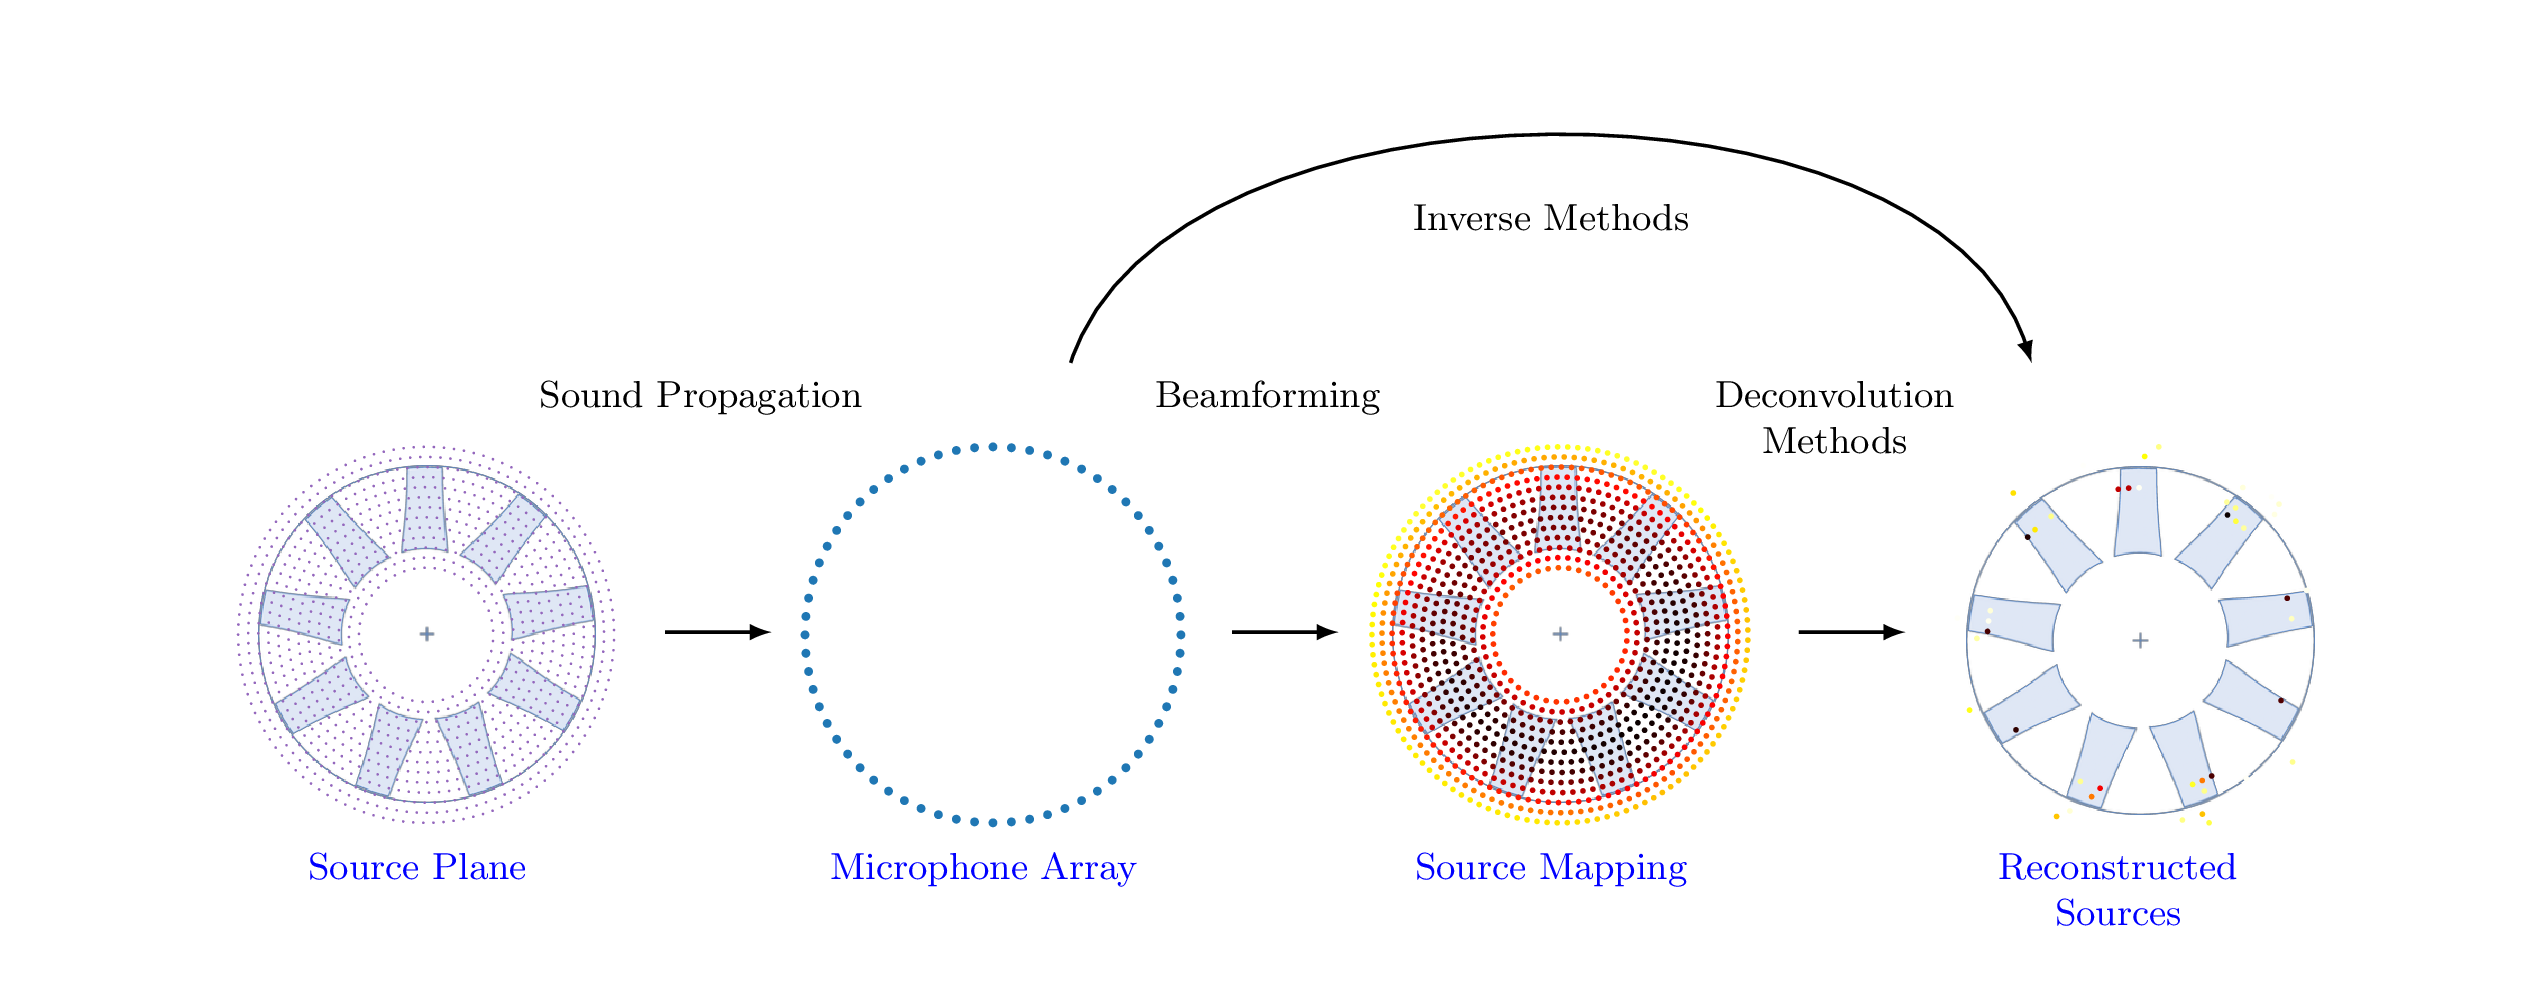

* **Beamforming Methods**: Spatial filtering to determine the contribution of sound sources
* **Deconvolution Methods**: Aim to improve spatial resolution by minimizing the influence of the point spread function (PSF), i.e. the spatial filter response
* **Inverse Methods**: Solve an inverse mathematical problem to recover the strength and location of sources without using beamforming as an intermediate step


**Implementations in Acoular**:

| Method                      | Type      | Acoular Class Name                                      |
|-----------------------------|------------|------------------------------------------------|
| [Delay-and-sum Beamforming](http://acoular.org/api_ref/generated/generated/acoular.tbeamform.BeamformerTime)   | Beamforming       | `BeamformerTime`    |
| [Conventional Beamforming](http://acoular.org/api_ref/generated/generated/acoular.fbeamform.BeamformerBase)    | Beamforming  | `BeamformerBase`    |
| [Functional Beamforming](http://acoular.org/api_ref/generated/generated/acoular.fbeamform.BeamformerFunctional) | Beamforming  | `BeamformerFunctional` |
| [Capon](http://acoular.org/api_ref/generated/generated/acoular.fbeamform.BeamformerCapon)                       | Beamforming  | `BeamformerCapon`   |
| [Eigenvalue Beamforming](http://acoular.org/api_ref/generated/generated/acoular.fbeamform.BeamformerEig)       | Beamforming  | `BeamformerEig`     |
| [MUSIC](http://acoular.org/api_ref/generated/generated/acoular.fbeamform.BeamformerMusic)                       | Beamforming  | `BeamformerMusic`   |
| [CLEAN-SC](http://acoular.org/api_ref/generated/generated/acoular.fbeamform.BeamformerCleansc)         | Deconvolution       | `BeamformerCleansc` |
| [CLEAN](http://acoular.org/api_ref/generated/generated/acoular.fbeamform.BeamformerClean)                       | Deconvolution  | `BeamformerClean`   |
| [CLEAN-T](http://acoular.org/api_ref/generated/generated/acoular.tbeamform.BeamformerCleant)                       | Deconvolution  | `BeamformerCleant`   |
| [DAMAS](http://acoular.org/api_ref/generated/generated/acoular.fbeamform.BeamformerDamas)             | Deconvolution       | `BeamformerDamas`, `BeamformerDamasPlus` |
| [Orthogonal Beamforming](http://acoular.org/api_ref/generated/generated/acoular.fbeamform.BeamformerOrth)               | Deconvolution       | `BeamformerOrth`, `BeamformerGridlessOrth`  |
| [CMF](http://acoular.org/api_ref/generated/generated/acoular.fbeamform.BeamformerCMF)                   | Inverse       | `BeamformerCMF`     |
| [SODIX](http://acoular.org/api_ref/generated/generated/acoular.fbeamform.BeamformerSODIX)               | Inverse       | `BeamformerSODIX`   |
| [GIB](http://acoular.org/api_ref/generated/generated/acoular.fbeamform.BeamformerGIB)                   | Inverse       | `BeamformerGIB`     |



### Conventional Frequency Domain Beamforming <a href="https://doi.org/10.1121/1.4986933">[5]</a>

* Calculates the squared sound pressure at a reference point (array center) for $G$ grid points

$$
b\left(\mathbf{x}_t\right)=\mathbf{h}^{\mathrm{H}}\left(\mathbf{x}_t\right) \mathbf{C} \mathbf{h}\left(\mathbf{x}_t\right), \quad t=1 \ldots G
$$

In [ ]:
# Define the steering vector and beamformer
steer = ac.SteeringVector(
    grid=grid, mics=mics, env=env, ref=np.array([0,0,0]), steer_type='true level')

# setup Conventional Beamforming
beamformer = ac.BeamformerBase(steer=steer, freq_data=freq_data)

# calculate result
smap = ac.L_p(beamformer.synthetic(2000, num=3))

%plot_beamforming

### Deconvolution Method

#### **CLEAN-SC** <a href="https://doi.org/10.1260/147547207783359459">[6]</a>: 

Iterative method to estimate the sound source distribution:

 1. **Find maximum** in the beamforming map $b^{(i)}(\mathbf{x}_{max})$
 2. **Calculate source component** and construct source cross spectral matrix $\mathbf{C}_s (\omega)$ 
 3. **Subtract** the source **contribution** ($\gamma$: damping factor)
 
 $$\mathbf{C}^{(i+1)}(\omega) =  \mathbf{C}^{(i)}(\omega) - \gamma\mathbf{C}_s (\omega)$$

 4. Recalculate the beamforming map and repeat the process

In [ ]:
deconvolution = ac.BeamformerCleansc(
    freq_data=freq_data, steer=steer, damp=0.6)

# calculate the results
smap = ac.L_p(deconvolution.synthetic(2000, num=3))

%plot_deconvolution

## Inverse Methods

#### Covariance Matrix Fitting (CMF) <a href="http://dx.doi.org/10.1121/1.2896754">[7]</a>:

- The goal is to fit** the **modeled** CSM to the **measured** CSM $ \mathbf{C} $
- Enforcing sparsity (few active sources) leads to the **Lasso-based formulation**:

  $$
  \underset{\mathbf{D}}{\arg \min} \left( \left\| \hat{\mathbf{G}} - \mathbf{A D A}^H \right\|_F^2 + \alpha \|\mathbf{D}\|_1 \right), \quad d_{ii} \geq 0
  $$

where:
  - $ \mathbf{A} $ is an $ M \times G $ transfer function matrix
  - $ \mathbf{D} $ is an $ G \times G $ diagonal matrix of source strengths
  - $ \|\mathbf{D}\|_1 $ promotes sparse solutions.
  - $ \alpha $ is a regularization parameter.

Can be solved with:
  - Least Angle Regression with L1 penalty <a href="https://doi.org/10.1214/009053604000000067">[8]</a>:
  - Hyperparameter $ \alpha $ is chosen using the **Bayesian Information Criterion (BIC)**


In [ ]:
inverse = ac.BeamformerCMF(freq_data=freq_data, steer=steer, method='LassoLarsBIC')

# calculate the results
smap = ac.L_p(inverse.synthetic(2000, num=3))

%plot_inverse


## Acoustic Spectra Analysis



* Squared sound pressure integration over a sector to recover power spectra for the trailing and leading edge of a fan blade

**Computational Steps:**
* Define trailing and leading edge sectors using Acoular's [MultiSector](https://www.acoular.org/api_ref/generated/generated/acoular.grids.MultiSector.html#acoular.grids.PolySector) and [PolySector](https://www.acoular.org/api_ref/generated/generated/acoular.grids.PolySector.html#acoular.grids.PolySector) class
* Integrate the squared sound pressure over the sectors using the `integrate` method

In [ ]:
%plot_sectors

In [ ]:
# Define trailing edges of the first sector
trailing_edges = np.array([[0, 0.15], [-0.05, 0.15], [-0.05, 0.245], [0, 0.25]]).T

# define the sectors for the trailing and leading edges
trailing_sector = ac.MultiSector(sectors=[])

for i_blade in range(9):
    # create the sectors
    angle = i_blade * 40

    # append the trailing sector
    trailing_sector.sectors.append(
        ac.PolySector(edges = rotate_edges(trailing_edges, angle))
    )

# integrate the sectors
trailing_edges_spectrum = deconvolution.integrate(sector=trailing_sector)

print(trailing_edges_spectrum.shape)

%plot_spectra


<h2>References</h2>
<ol>
    <li style="margin-bottom: 10px;" id="Zenger2016">Zenger, F. J., Herold, G., Becker, S., & Sarradj, E. (2016). <i>Sound source localization on an axial fan at different operating points</i>. Experiments in Fluids, 57(136), 1-10. <a href="https://doi.org/10.1007/s00348-016-2223-8">https://doi.org/10.1007/s00348-016-2223-8</a></li>
    <li style="margin-bottom: 10px;" id="Herold2015a">Herold, G., & Sarradj, E. (2015). <i>Microphone array method for the characterization of rotating sound sources in axial fans</i>. Noise Control Engineering Journal, 63(6), 546-551. <a href="https://doi.org/10.3397/1/376348">https://doi.org/10.3397/1/376348</a></li>
    <li style="margin-bottom: 10px;" id="Welch1967">Welch, P. D. (1967). <i>The use of fast Fourier transform for the estimation of power spectra: A method based on time averaging over short, modified periodograms</i>. IEEE Transactions on Audio and Electroacoustics, 15(2), 70-73. <a href="https://doi.org/10.1109/TAU.1967.1161901">https://doi.org/10.1109/TAU.1967.1161901</a></li>
    <li style="margin-bottom: 10px;" id="Sarradj2016a">Sarradj, E. (2016). <i>A fast ray casting method for sound refraction at shear layers</i>. In 22nd AIAA/CEAS Aeroacoustics Conference. American Institute of Aeronautics and Astronautics. <a href="https://doi.org/10.2514/6.2016-2762">https://doi.org/10.2514/6.2016-2762</a></li>
    <li style="margin-bottom: 10px;" id="Merino-Martinez2019">Merino-Martínez, R., Sijtsma, P., Snellen, M., Ahlefeldt, T., Antoni, J., Bahr, C. J., Blacodon, D., Ernst, D., Finez, A., Funke, S., Geyer, T. F., Haxter, S., Herold, G., Huang, X., Humphreys, W. M., Leclère, Q., Malgoezar, A., Michel, U., Padois, T., Pereira, A., Picard, C., Sarradj, E., Siller, H., Simons, D. G., & Spehr, C. (2019). <i>A review of acoustic imaging methods using phased microphone arrays</i>. CEAS Aeronautical Journal, 10, 1-25. <a href="https://doi.org/10.1007/s13272-019-00383-4">https://doi.org/10.1007/s13272-019-00383-4</a></li>
    <li style="margin-bottom: 10px;" id="Sijtsma2007">Sijtsma, P. (2007). <i>CLEAN Based on Spatial Source Coherence</i>. International Journal of Aeroacoustics, 6(4), 357-374. <a href="https://doi.org/10.1260/147547207783359459">https://doi.org/10.1260/147547207783359459</a></li>
    <li style="margin-bottom: 10px;" id="Yardibi2008">Yardibi, T., Li, J., Stoica, P., & Cattafesta, L. N. (2008). <i>Sparsity constrained deconvolution approaches for acoustic source mapping</i>. The Journal of the Acoustical Society of America, 123(5), 2631-2642. <a href="http://dx.doi.org/10.1121/1.2896754">http://dx.doi.org/10.1121/1.2896754</a></li>
    <li style="margin-bottom: 10px;" id="Efron2004">Efron, B., Hastie, T., Johnstone, I., & Tibshirani, R. (2004). <i>Least angle regression</i>. The Annals of Statistics, 32(2), 407-499. <a href="https://doi.org/10.1214/009053604000000067">https://doi.org/10.1214/009053604000000067</a></li>
    <li style="margin-bottom: 10px;" id="Acoular2017">Sarradj, E., & Herold, G. (2017). <i>A Python framework for microphone array data processing</i>. Applied Acoustics, 116, 50-58. <a href="https://doi.org/10.1016/j.apacoust.2016.09.015">https://doi.org/10.1016/j.apacoust.2016.09.015</a></li>
</ol>

## Acoular Future Directions Survey – Don't forget to participate! 

<img src="img/survey.png" alt="Survey" style="height: auto; width: 50%;">